In [2]:
%config Completer.use_jedi = False

# Data load and print head

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd

In [4]:
train = pd.read_csv('../data/original_data/train.csv')
test = pd.read_csv('../data/original_data/test.csv')
combine = [train, test]

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## check imbalance

In [7]:
train["count"] = 1
train[["Survived","count"]].groupby("Survived").sum()/len(train)

,count
Survived,
0,0.616162
1,0.383838


- 생존자와 사망자 사이의 데이터 값이 2배 가까이 차이가 나는 것을 확인할 수 있다.
- 이 부분을 보완하기위해서 smote 기법을 사용할 수 있는데 이를 위해서 데이터를 수치화하고 결측치를 채워넣어야한다.

In [8]:
print("="*40)
train.info()
print("+"*40)
test.info()
print("="*40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  count        891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB
++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------   

- 우선 object 타입을 가진 데이터는 Name, Sex, Ticket, Cabin, Embarked 네가지가 있고 이 데이터를 수치화 시켜줘야 한다.
- Cabin의 경우는 train, test 모두 null 값이 대부분인 것을 알 수 있다.
- null의 개수를 더 정확하게 출력해보자.

In [9]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
count            0
dtype: int64

In [10]:
print("train      Age null ratio ::: ", 177 / 891 * 100)
print("train    Cabin null ratio ::: ", 687 / 891 * 100)
print("train Embarked null ratio ::: ", 2 / 891 * 100)

train      Age null ratio :::  19.865319865319865
train    Cabin null ratio :::  77.10437710437711
train Embarked null ratio :::  0.22446689113355783


- train의 경우 Age, Cabin, Embarked 에서 결측치가 있다.
- Cabin은 결측률이 77 퍼센트로 매우 높다. 이럴 경우 정확하게 Cabin 을 분배한 규칙을 알지 못하므로 예측을 위한 데이터로 쓰기 힘들다.
- Age의 결측률도 19% 정도로 Survived 와 연관성을 확인하고 버릴지 말지 결정해야한다.

In [11]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [12]:
print("test      Age null ratio ::: ", 86 / 891 * 100)
print("test     Fare null ratio ::: ", 1 / 891 * 100)
print("test    Cabin null ratio ::: ", 327 / 891 * 100)

test      Age null ratio :::  9.652076318742985
test     Fare null ratio :::  0.11223344556677892
test    Cabin null ratio :::  36.7003367003367


- 우리가 예측해야하는 Survived 데이터가 없는 것을 알 수 있다.
- 여기서도 역시 Cabin의 결측률이 높은 것을 알 수 있다. train과 test 모두 높은 결측률을 보이므로 drop 하도록 한다.
- Age는 9퍼센트의 결측률을 보이므로 Survived와의 연관성을 파악하여 drop을 할지 말지 결정하자.

In [13]:
for dataset in combine:
    dataset.drop("Cabin", axis = 1, inplace = True)

In [14]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1


## Age data를 버려야 하는가?
 - 이 질문에 대답하기 위해서는 Age 데이터에 따라 살 수 있는 확률이 확실하게 갈리는지 봐야한다.
 - 따라서 Age 에 따른 생존자와 사망자의 kde를 그려보도록 한다.

<AxesSubplot:xlabel='Age', ylabel='Density'>

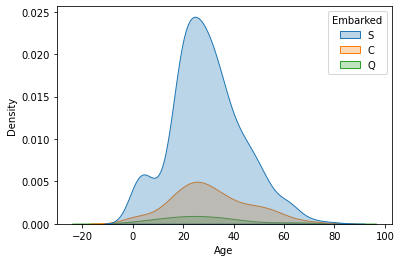

In [15]:
sns.kdeplot(
    data = train,
    x = "Age",
    hue = "Embarked",
    fill = True,
    alpha = 0.3
)

- 10세 부근을 기준으로 하여 대략 10세 이하일 경우 생존 확률이 높고 그렇지 못한 경우 확률이 낮은 것을 알 수 있다.
- 따라서 생존 여부를 판별할 수 있는 유의미한 데이터이므로 결측치를 채우기 위해서 다른 데이터와 어떤 관계를 지니는지 보아야 한다.

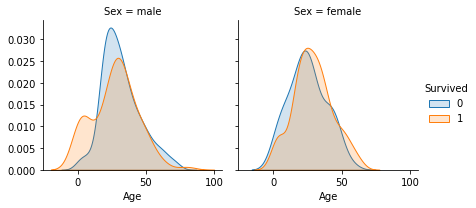

In [16]:
sns.FacetGrid(
    data = train,
    col = "Sex",
    hue = "Survived",
).map(
    sns.kdeplot,
    "Age",
    fill=True,
    alpha = 0.2,
    legend = True
).add_legend()

- 특정 연령대에 따라서 생존 확률이 나뉘는 것을 볼 수 있다.
- 하지만 분포가 비슷하여 남자와 여자라는 점이 연령을 추산할 수 있게 해주는 것은 아니다
- 가족관계로 부터 연령대를 추산하는 것이 가능할 것이다.
- SibSp과 Parch가 Age와 어떤 관계가 있는지 보자.

In [17]:
train[["SibSp","Parch","Age"]].describe()

,SibSp,Parch,Age
count,891.000000,891.000000,714.000000
mean,0.523008,0.381594,29.699118
std,1.102743,0.806057,14.526497
min,0.000000,0.000000,0.420000
25%,0.000000,0.000000,20.125000
50%,0.000000,0.000000,28.000000
75%,1.000000,0.000000,38.000000
max,8.000000,6.000000,80.000000


In [18]:
train[["SibSp","count"]].groupby("SibSp").sum()

,count
SibSp,
0,608
1,209
2,28
3,16
4,18
5,5
8,7


In [19]:
train[["Parch","count"]].groupby("Parch").sum()

,count
Parch,
0,678
1,118
2,80
3,5
4,4
5,5
6,1


- SibSp과 Parch 모두 0인 사람은 혼자 탔으므로 가족관계를 통해 연령을 유추하는 것이 불가능 하다.
- 다만 혼자 탔을 경우 어린이는 아닐 것이므로 혼자 탄 사람들의 그룹에서 연령을 유추하는 것이 가능하다.
- 가족이 1명 이상 있는 경우 모두 1과 2 혹은 그 이상으로 나누어 생각할 수 있다.

In [20]:
train["IsAlone"] = True
train.loc[
    (train["Parch"] > 0) &
    (train["SibSp"] > 0),
    "IsAlone"
] = False
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,count,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,1,True
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,1,True
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,1,False
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1,True


- 혼자 탑승한 사람들의 경우 어떤 연령 분포를 가지는지 보자.
- 만약 unimodal 하다면 난수를 생성하여 결측치를 채우는 것이 가능하다.

<AxesSubplot:xlabel='Age', ylabel='Density'>

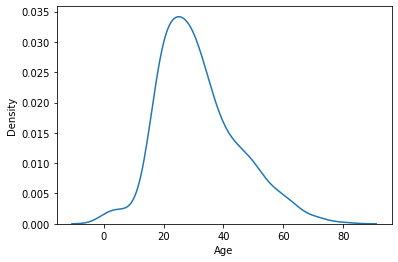

In [21]:
sns.kdeplot(
    data = train[train["IsAlone"] == True],
    x = "Age"
)

- 20 ~ 40세 사이에 모여있는 unimodal 분포인 것을 알 수 있다.
- mean과 std 구해서 uniform 분포로 부터 랜덤하게 결측치를 채울 수 있다.

In [22]:
null_size = train[train["IsAlone"] == True]["Age"].isnull().sum()
null_size

161

In [23]:
train[train["IsAlone"] == True]["Age"].describe()

count    588.000000
mean      31.524235
std       13.226134
min        0.420000
25%       22.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

In [24]:
IsAlone_Age_mean = train[train["IsAlone"] == True]["Age"].mean()
IsAlone_Age_std = train[train["IsAlone"] == True]["Age"].std()
print(IsAlone_Age_mean, IsAlone_Age_std)

31.524234693877553 13.22613372124623


In [25]:
random_Age_arr = np.random.randint(
    IsAlone_Age_mean - IsAlone_Age_std,
    IsAlone_Age_mean + IsAlone_Age_std,
    size = null_size
)
random_Age_arr.shape

(161,)

In [26]:
len(train[(train["IsAlone"] == True) & train["Age"].isnull()])

161

In [27]:
train.loc[(train["IsAlone"] == True) & train["Age"].isnull(), "Age"] = random_Age_arr
train[train["IsAlone"] == True]["Age"].isnull().sum()

0

<AxesSubplot:xlabel='Age', ylabel='Density'>

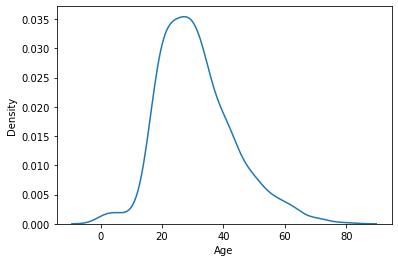

In [28]:
sns.kdeplot(
    data = train[train["IsAlone"] == True],
    x = 'Age',
)

- 결측치를 채우고 나서도 분포가 크게 변하지 않았다.
- test에도 동일한 처리를 해준다.

<AxesSubplot:xlabel='Age', ylabel='Density'>

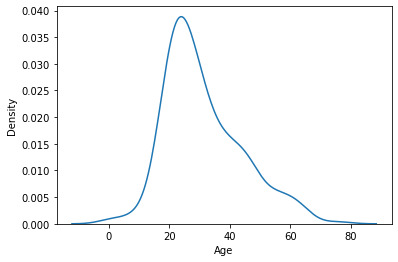

In [29]:
test["IsAlone"] = True
test.loc[
    (test["Parch"] > 0) &
    (test["SibSp"] > 0),
    "IsAlone"
] = False

sns.kdeplot(
    data = test[test["IsAlone"] == True],
    x = "Age"
)

In [30]:
null_size = test[test["IsAlone"] == True]["Age"].isnull().sum()

random_Age_arr = np.random.randint(
    IsAlone_Age_mean - IsAlone_Age_std,
    IsAlone_Age_mean + IsAlone_Age_std,
    size = null_size
) # train의 표본 특성을 그대로 사용한다.

test.loc[
    (test["IsAlone"] == True)&
    (test["Age"].isnull()),
    "Age"
] = random_Age_arr

<AxesSubplot:xlabel='Age', ylabel='Density'>

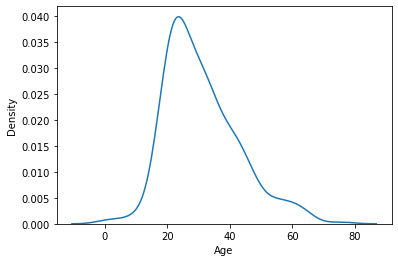

In [31]:
sns.kdeplot(
    data = test[(test["IsAlone"] == True)],
    x = 'Age',
)

- 이제는 혼자 탑승하지 않은 사람들의 분포를 보자.
- 그러기 위해서 SibSpBand와 ParchBand를 나누어 생각하자.
- 각 밴드들은 1, 2, 그 외 값 으로 나뉜다.

In [32]:
targets = ["SibSp", "Parch"]
bands = ["SibSpBand","ParchBand"]
for dataset in combine:
    for t,b in zip(targets, bands):
        dataset[b] = 0
        dataset.loc[(dataset[t] == 1), b] = 1
        dataset.loc[(dataset[t] == 2), b] = 2
        dataset.loc[(dataset[t] > 2), b] = 3
        
        
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,count,IsAlone,SibSpBand,ParchBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,True,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,True,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,True,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,True,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,True,0,0


- SibSp과 Parch 에 따라서 연령분포의 차이가 있으면 해당 Band로 부터 mean, std 구해서 난수 발생 가능하다.
- 그려보자.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


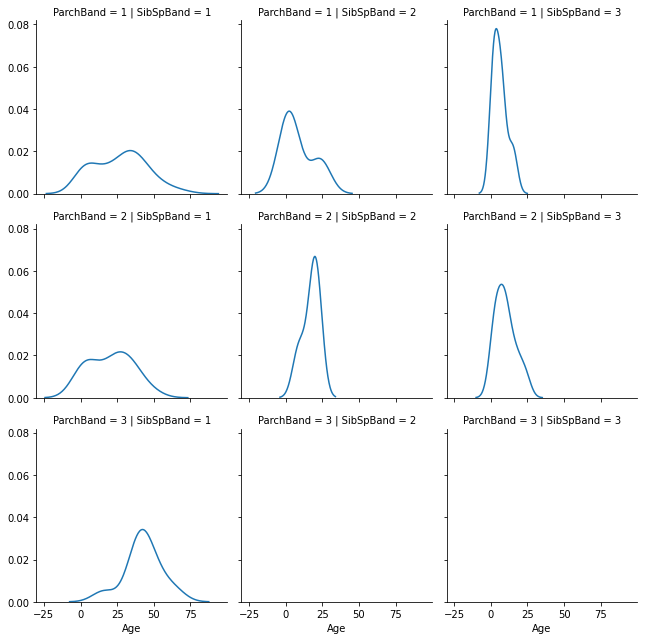

In [33]:
sns.FacetGrid(
    data = train[train["IsAlone"] == False],
    row = "ParchBand",
    col = "SibSpBand"
    #hue = "Sex"
).map(
    sns.kdeplot,
    "Age",
).add_legend()

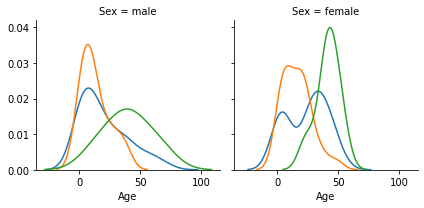

In [34]:
sns.FacetGrid(
    data = train[train["IsAlone"] == False],
    col = "Sex",
    hue = "ParchBand"
).map(
    sns.kdeplot,
    "Age"
)

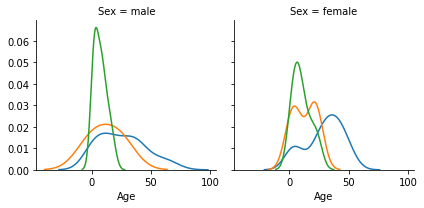

In [35]:
sns.FacetGrid(
    data = train[train["IsAlone"] == False],
    col = "Sex",
    hue = "SibSpBand"
).map(
    sns.kdeplot,
    "Age"
)

- SibSp와 Parch만 가지고는 생각보다 연령을 구분하기 쉽지 않았다.
- 그렇다면 이번에는 운임요금이 저렴하면 연령대가 어릴것이라는 추측을 해볼 수 있다.
- 운임요금은 Pclass에 따라 달라지므로 Plass와 FareBand에 따라서 비교해보자.

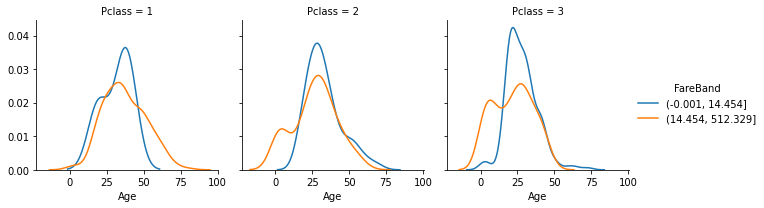

In [36]:
train["FareBand"] = pd.qcut(train["Fare"],2)
sns.FacetGrid(
    data = train,
    col = "Pclass",
    hue = "FareBand"
).map(
    sns.kdeplot,
    "Age"
).add_legend()

- 분포를 보면 잘 구분 할 수 없다는 것을 알 수 있다.

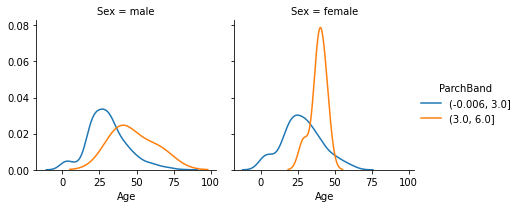

In [39]:
train["ParchBand"] = pd.cut(train["Parch"],2)
sns.FacetGrid(
    data = train,
    col = "Sex",
    hue = "ParchBand"
).map(
    sns.kdeplot,
    "Age"
).add_legend()

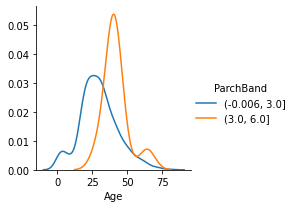

In [40]:
train["ParchBand"] = pd.cut(train["Parch"],2)
sns.FacetGrid(
    data = train,
    hue = "ParchBand"
).map(
    sns.kdeplot,
    "Age"
).add_legend()

- 동승자가 있는 경우 ParchBand를 2로 cut 하면 성별에 관계없이 연령츨리 나뉘는 것을 볼 수 있다.
- 이 특성에 따라 남은 나이의 결측치를 채워주자.

In [41]:
train["Parch"].isnull().sum()

0

- Parch값은 결측치가 없으므로 남은 null값을 모두 채워줄 수 있다.

In [42]:
mean = train[train["Parch"] <= 3]["Age"].mean()
std = train[train["Parch"] <= 3]["Age"].std()

for dataset in combine:
    num_null = dataset[dataset["Parch"] <= 3]["Age"].isnull().sum()

    dataset.loc[
        (dataset["Parch"]<=3) &
        (dataset["Age"].isnull()),
        "Age"
    ] = np.random.randint(mean-std, mean+std, size = num_null)    

train["Age"].isnull().sum()

0

In [43]:
mean = train[train["Parch"] > 3]["Age"].mean()
std = train[train["Parch"] > 3]["Age"].std()

for dataset in combine:
    num_null = dataset[dataset["Parch"] >3]["Age"].isnull().sum()

    dataset.loc[
        (dataset["Parch"]>3) &
        (dataset["Age"].isnull()),
        "Age"
    ] = np.random.randint(mean-std, mean+std, size = num_null)    

train["Age"].isnull().sum()

0

## 이제 Age 를 다 채웠다.

In [44]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
count          0
IsAlone        0
SibSpBand      0
ParchBand      0
FareBand       0
dtype: int64

In [45]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
IsAlone        0
SibSpBand      0
ParchBand      0
dtype: int64

- train에 Embarked 하나 남았고 test에 Fare 하나 남았다.
- Embarked 는 최빈값을 넣어주도록 하자.

In [46]:
train[["Embarked","count"]].groupby("Embarked").sum()

,count
Embarked,
C,168
Q,77
S,644


In [47]:
train["Embarked"].fillna("S", inplace=True)
train["Embarked"].replace({"Q":1, "C":2, "S":3}, inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,count,IsAlone,SibSpBand,ParchBand,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,3,1,True,1,"(-0.006, 3.0]","(-0.001, 14.454]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,1,True,1,"(-0.006, 3.0]","(14.454, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,3,1,True,0,"(-0.006, 3.0]","(-0.001, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,3,1,True,1,"(-0.006, 3.0]","(14.454, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,3,1,True,0,"(-0.006, 3.0]","(-0.001, 14.454]"


- test는 같은 티켓을 구매한 사람이 있는지 확인해 본다.

In [48]:
test[test["Fare"].isnull()]["Ticket"]

152    3701
Name: Ticket, dtype: object

In [49]:
test[test["Ticket"] == "3701"]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,IsAlone,SibSpBand,ParchBand
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,True,0,0


- 같은 티켓 없다.
- 심지어 혼자 탔다.
- 아까 나이에 따른 가격 변동은 없는 것으로 확인 했으므로 Pclass에 따른 가격을 IsAlone에 대해서 보자.

In [50]:
test[test["IsAlone"]==True][["Pclass","Fare"]].groupby("Pclass").agg(['mean','std'])

Fare           
             mean        std
Pclass                      
1       80.396679  77.531793
2       20.212029  12.756904
3        9.798099   5.617948

In [52]:
test["Fare"].fillna(test[(test["IsAlone"]==True) & (test["Pclass"] == 3)]["Fare"].mean(),inplace = True)
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
IsAlone        0
SibSpBand      0
ParchBand      0
dtype: int64

In [53]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
count          0
IsAlone        0
SibSpBand      0
ParchBand      0
FareBand       0
dtype: int64

- 모든 결측치가 채워졌다.

In [54]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,count,IsAlone,SibSpBand,ParchBand,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,3,1,True,1,"(-0.006, 3.0]","(-0.001, 14.454]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,1,True,1,"(-0.006, 3.0]","(14.454, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,3,1,True,0,"(-0.006, 3.0]","(-0.001, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,3,1,True,1,"(-0.006, 3.0]","(14.454, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,3,1,True,0,"(-0.006, 3.0]","(-0.001, 14.454]"


In [55]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,IsAlone,SibSpBand,ParchBand
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,True,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,True,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,True,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,True,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,False,1,1


- 이제는 본격적으로 각 열들이 생존과 얼마나 관련이 있는지 알아내야한다.
- 우선은 성별을 숫자로 바꿔준다.

In [56]:
Sex_map = {
    "male" : 1,
    "female" : 2
}

for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map(Sex_map)

    print("="*40)
    dataset.info()

print("="*40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    int64   
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    int64   
 11  count        891 non-null    int64   
 12  IsAlone      891 non-null    bool    
 13  SibSpBand    891 non-null    int64   
 14  ParchBand    891 non-null    category
 15  FareBand     891 non-null    category
dtypes: bool(1), category(2), float64(2), int64(9), object(2)
memory usage: 93.4+ KB
<class 'pandas.core.frame.DataFrame'

- 나이를 예측하기 위해 만들었던 SibSpBand, ParchBand, FareBand 없애준다.

In [57]:
train.drop(["SibSpBand","ParchBand","FareBand"], axis = 1, inplace = True)
test.drop(["SibSpBand","ParchBand"], axis = 1, inplace = True)

print('='*40)
train.info()
print('='*40)
test.info()
print('='*40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    int64  
 11  count        891 non-null    int64  
 12  IsAlone      891 non-null    bool   
dtypes: bool(1), float64(2), int64(8), object(2)
memory usage: 84.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

In [58]:
test["Embarked"].replace({"Q":1, "C":2, "S":3}, inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    int64  
 10  IsAlone      418 non-null    bool   
dtypes: bool(1), float64(2), int64(6), object(2)
memory usage: 33.2+ KB


- Ticket 을 버려준다.

In [59]:
for dataset in combine:
    dataset.drop("Ticket", axis = 1, inplace = True)
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int64  
 10  count        891 non-null    int64  
 11  IsAlone      891 non-null    bool   
dtypes: bool(1), float64(2), int64(8), object(1)
memory usage: 77.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1  

- 이름에서 호칭을 가지고 온다.

In [60]:
train["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [61]:
for dataset in combine:
    dataset["Name"] = dataset["Name"].str.extract(" ([A-Za-z]+)\.")
train["Name"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Name, dtype: object

In [62]:
train[["Name","count","Survived"]].groupby("Name").agg(["sum","mean"])

count      Survived          
           sum mean      sum      mean
Name                                  
Capt         1    1        0  0.000000
Col          2    1        1  0.500000
Countess     1    1        1  1.000000
Don          1    1        0  0.000000
Dr           7    1        3  0.428571
Jonkheer     1    1        0  0.000000
Lady         1    1        1  1.000000
Major        2    1        1  0.500000
Master      40    1       23  0.575000
Miss       182    1      127  0.697802
Mlle         2    1        2  1.000000
Mme          1    1        1  1.000000
Mr         517    1       81  0.156673
Mrs        125    1       99  0.792000
Ms           1    1        1  1.000000
Rev          6    1        0  0.000000
Sir          1    1        1  1.000000

In [63]:
def fn(x):
    if x == "Mr":
        return 1
    elif x == "Miss":
        return 2
    elif x == "Mrs":
        return 3
    elif x == "Master":
        return 4
    else:
        return 5
    

for dataset in combine:
    dataset["Title"] = dataset["Name"].map(fn)
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int64  
 10  count        891 non-null    int64  
 11  IsAlone      891 non-null    bool   
 12  Title        891 non-null    int64  
dtypes: bool(1), float64(2), int64(9), object(1)
memory usage: 84.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

In [64]:
train[["Title","Survived"]].groupby("Title").mean()

,Survived
Title,
1,0.156673
2,0.697802
3,0.792000
4,0.575000
5,0.444444


- 타이틀에 따라 생존율이 유의미한 차이들을 보인다. 따라서 구분 가능하다고 할 수 있다.
- 이제 Name은 버린다.

In [65]:
for dataset in combine:
    del dataset["Name"]
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
 9   count        891 non-null    int64  
 10  IsAlone      891 non-null    bool   
 11  Title        891 non-null    int64  
dtypes: bool(1), float64(2), int64(9)
memory usage: 77.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass     

- 이번에는 연속변수인 Fare를 구간별로 나누어보자.
- 아까는 연령을 구분하기 위함이었지만 지금은 Survived와 어떤 관계를 지니는지 알아야한다.

In [66]:
train["_FareBand"] = pd.cut(train["Fare"],4,)
train[["_FareBand", "Survived"]].groupby("_FareBand").mean()

,Survived
_FareBand,
"(-0.512, 128.082]",0.368113
"(128.082, 256.165]",0.724138
"(256.165, 384.247]",0.666667
"(384.247, 512.329]",1.000000


In [70]:
15 in train["_FareBand"].unique()

True

In [71]:
for dataset in combine:
    #for i, band in enumerate(train["_FareBand"].unique()):
    dataset.loc[dataset["Fare"]<= 128.082,"FareBand"] = 1
    dataset.loc[(dataset["Fare"]> 128.082) & (dataset["Fare"]<= 256.165),"FareBand"] = 1
    dataset.loc[(dataset["Fare"]> 256.165) & dataset["Fare"]<= 384.247,"FareBand"] = 1
    dataset.loc[dataset["Fare"]> 384.247,"FareBand"] = 1

train.drop("_FareBand", axis = 1, inplace = True)   
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,count,IsAlone,Title,FareBand
0,1,0,3,1,22.0,1,0,7.2500,3,1,True,1,1.0
1,2,1,1,2,38.0,1,0,71.2833,2,1,True,3,1.0
2,3,1,3,2,26.0,0,0,7.9250,3,1,True,2,1.0
3,4,1,1,2,35.0,1,0,53.1000,3,1,True,3,1.0
4,5,0,3,1,35.0,0,0,8.0500,3,1,True,1,1.0


In [72]:
for dataset in combine:
    dataset["IsAlone"].replace({True : 1, False : 2}, inplace = True)
del train["count"]
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,Title,FareBand
0,1,0,3,1,22.0,1,0,7.2500,3,1,1,1.0
1,2,1,1,2,38.0,1,0,71.2833,2,1,3,1.0
2,3,1,3,2,26.0,0,0,7.9250,3,1,2,1.0
3,4,1,1,2,35.0,1,0,53.1000,3,1,3,1.0
4,5,0,3,1,35.0,0,0,8.0500,3,1,1,1.0


In [73]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,Title,FareBand
0,892,3,1,34.5,0,0,7.8292,1,1,1,1.0
1,893,3,2,47.0,1,0,7.0000,3,1,3,1.0
2,894,2,1,62.0,0,0,9.6875,1,1,1,1.0
3,895,3,1,27.0,0,0,8.6625,3,1,1,1.0
4,896,3,2,22.0,1,1,12.2875,3,2,3,1.0


In [74]:
train[train["FareBand"].isnull()]#["Fare"].map(lambda x : x in band)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,Title,FareBand


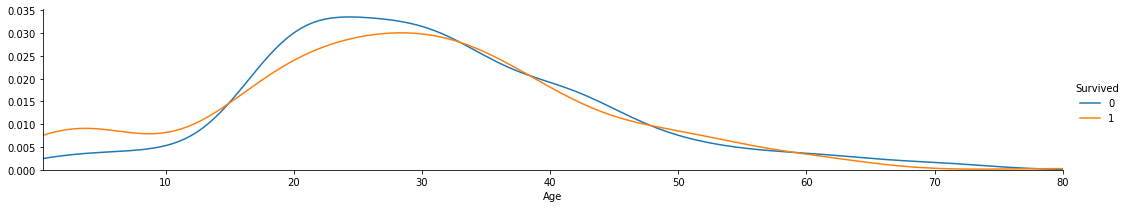

In [75]:
sns.FacetGrid(
    data = train,
    hue = "Survived",
    aspect=5,
    xlim = [train["Age"].min(),train["Age"].max()]
).map(
    sns.kdeplot,
    "Age"
).add_legend()

In [76]:
train["_AgeBand"] = pd.cut(train["Age"],[train["Age"].min(),15,30,40,50,60,train["Age"].max()])
train[["_AgeBand","Survived"]].groupby("_AgeBand").mean()

,Survived
_AgeBand,
"(0.42, 15.0]",0.585366
"(15.0, 30.0]",0.347826
"(30.0, 40.0]",0.402715
"(40.0, 50.0]",0.348624
"(50.0, 60.0]",0.404762
"(60.0, 80.0]",0.227273


In [77]:
for dataset in combine:
    dataset.loc[(dataset["Age"] <= 15),"AgeBand"] = 1
    dataset.loc[(dataset["Age"] > 15) & (dataset["Age"] <= 30),"AgeBand"] = 2
    dataset.loc[(dataset["Age"] > 30) & (dataset["Age"] <= 40),"AgeBand"] = 3
    dataset.loc[(dataset["Age"] > 40) & (dataset["Age"] <= 50),"AgeBand"] = 4
    dataset.loc[(dataset["Age"] > 50) & (dataset["Age"] <= 60),"AgeBand"] = 5
    dataset.loc[(dataset["Age"] > 60),"AgeBand"] = 6
train.drop("_AgeBand", axis = 1, inplace = True)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,Title,FareBand,AgeBand
0,1,0,3,1,22.0,1,0,7.2500,3,1,1,1.0,2.0
1,2,1,1,2,38.0,1,0,71.2833,2,1,3,1.0,3.0
2,3,1,3,2,26.0,0,0,7.9250,3,1,2,1.0,2.0
3,4,1,1,2,35.0,1,0,53.1000,3,1,3,1.0,3.0
4,5,0,3,1,35.0,0,0,8.0500,3,1,1,1.0,3.0


In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # Z = (X-maen)/std

In [71]:
SSc = StandardScaler()

In [72]:
pca = PCA(n_components = 2)

In [73]:
drop_list = [
    "PassengerId",
    "Survived", 
    #"Pclass",
    #"Sex",
    "Age",
    #"SibSp", 
    #"Parch",
    "Fare",
    #"Embarked",
    #"IsAlone",
    #"Title",
    #"FareBand",
    #"AgeBand"
]

# SSc -> fit -> transform

scaled = SSc.fit_transform(train.drop(drop_list, axis = 1))
principalComponents = pca.fit_transform(scaled)
principalComponents

array([[-0.59461069, -1.44234224],
       [ 0.45999065,  2.37072755],
       [-0.04812712,  0.14010749],
       ...,
       [ 2.86019735, -0.29601945],
       [-1.11261175,  0.38614501],
       [-1.30969827, -0.37657685]])

In [74]:
pca_df = pd.DataFrame(principalComponents, columns=["V1", "V2"])
pca_df.head()

,V1,V2
0,-0.594611,-1.442342
1,0.459991,2.370728
2,-0.048127,0.140107
3,0.520440,2.104658
4,-1.188800,-0.908715


In [75]:
pca_df = pd.concat([train[["Survived"]], pca_df], axis = 1)
pca_df

,Survived,V1,V2
0,0,-0.594611,-1.442342
1,1,0.459991,2.370728
2,1,-0.048127,0.140107
3,1,0.520440,2.104658
4,0,-1.188800,-0.908715
...,...,...,...
886,0,0.397681,1.095147
887,1,-0.084866,1.519945
888,0,2.860197,-0.296019
889,1,-1.112612,0.386145


<AxesSubplot:xlabel='V1', ylabel='V2'>

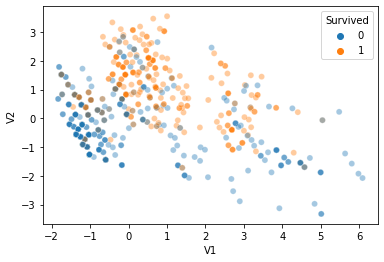

In [76]:
sns.scatterplot(
    data = pca_df,
    x = "V1",
    y = "V2",
    hue = "Survived",
    alpha = 0.4
)

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
MAX_DEPTH = [3]#,5,7,9,11]
for MD in MAX_DEPTH:
    RFC = RandomForestClassifier(
        n_estimators=500,
        max_depth = MD
    )
    RFC.fit(pca_df[["V1","V2"]],pca_df["Survived"])
    print("MAX_DEPTH ::: ", RFC.score(pca_df[["V1","V2"]],pca_df["Survived"]))
    _pred = RFC.predict(
        pca.transform(
            SSc.transform(
                test.drop(["PassengerId","Age","Fare"], axis=1)
            )
        )
    )
    pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived" : _pred}).to_csv(f"RFC_MAX_DEPTH_{MD}_500est.csv", index = False)

MAX_DEPTH :::  0.8024691358024691


In [82]:
from lightgbm import LGBMClassifier

In [83]:
lgbm = LGBMClassifier()

In [84]:
lgbm.fit(pca_df[["V1","V2"]],pca_df["Survived"])

LGBMClassifier()

In [87]:
prediction = lgbm.predict(
    pca.transform(
        SSc.transform(
            test.drop(["PassengerId","Age","Fare"], axis=1)
        )
    )
)

In [88]:
pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived" : prediction}).to_csv("lgbm.csv", index = False)

In [90]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,Title,FareBand,AgeBand
0,1,0,3,1,22.0,1,0,7.2500,3,1,1,1.0,2.0
1,2,1,1,2,38.0,1,0,71.2833,2,1,3,1.0,3.0
2,3,1,3,2,26.0,0,0,7.9250,3,1,2,1.0,2.0
3,4,1,1,2,35.0,1,0,53.1000,3,1,3,1.0,3.0
4,5,0,3,1,35.0,0,0,8.0500,3,1,1,1.0,3.0


In [99]:
lgbm2 = LGBMClassifier()
lgbm2.fit(train[["Pclass","Sex","AgeBand","FareBand","Embarked","IsAlone","Title"]],train["Survived"])
lgbm2.score(train[["Pclass","Sex","AgeBand","FareBand","Embarked","IsAlone","Title"]],train["Survived"])

0.8395061728395061

In [101]:
prediction = lgbm2.predict(test[["Pclass","Sex","AgeBand","FareBand","Embarked","IsAlone","Title"]])
pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived" : prediction}).to_csv("lgbm3.csv", index = False)

In [102]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,Title,FareBand,AgeBand
0,1,0,3,1,22.0,1,0,7.2500,3,1,1,1.0,2.0
1,2,1,1,2,38.0,1,0,71.2833,2,1,3,1.0,3.0
2,3,1,3,2,26.0,0,0,7.9250,3,1,2,1.0,2.0
3,4,1,1,2,35.0,1,0,53.1000,3,1,3,1.0,3.0
4,5,0,3,1,35.0,0,0,8.0500,3,1,1,1.0,3.0


<AxesSubplot:xlabel='Age', ylabel='Sex'>

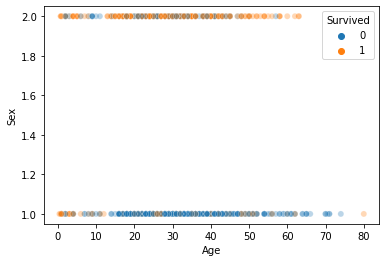

In [115]:
sns.scatterplot(
    data = train,
    x = "Age",
    y = "Sex",
    hue = "Survived",
    alpha = 0.3
)

<AxesSubplot:xlabel='Pclass'>

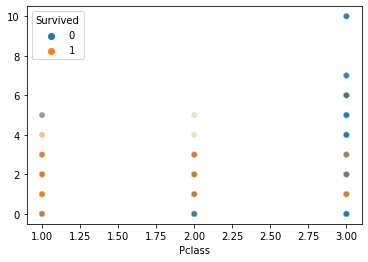

In [121]:
sns.scatterplot(
    data = train,
    x = "Pclass",
    y = train["SibSp"]+train["Parch"],
    hue = "Survived",
    alpha = 0.3
)

<AxesSubplot:ylabel='Embarked'>

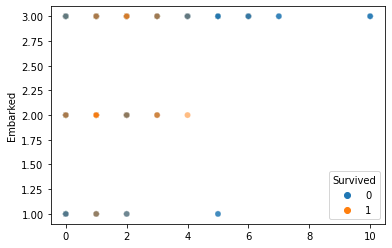

In [125]:
sns.scatterplot(
    data = train,
    x = train["SibSp"]+train["Parch"],
    y = "Embarked",
    hue = "Survived",
    alpha = 0.3
)

<AxesSubplot:xlabel='Age', ylabel='Fare'>

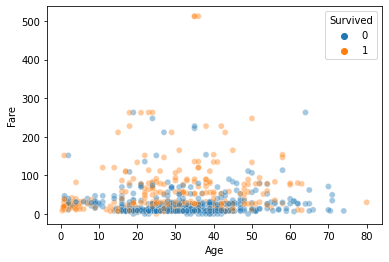

In [104]:
sns.scatterplot(
    data = train,
    x = "Age",
    y = "Fare",
    hue = "Survived",
    alpha = 0.4
)

## 이것은 마크다운입니다.

- [ ] 할일
- [X] 한일

In [82]:
df = pd.DataFrame({"Log" : ' "152533" "-" "http://182.227.69.137:28888/notebooks/my_code/PCA_smote_lightGBM_RFC.ipynb" '}, index=[1])

In [83]:
df

,Log
1,"""152533"" ""-"" ""http://182.227.69.137:28888/not..."


In [89]:
df["Log"].str.extract('( "http://.+" )')

,0
1,"""http://182.227.69.137:28888/notebooks/my_cod..."
